# Анализ данных сервиса аренды самокатов GoFast

 В данном проекте проведен анализ данных сервиса аренды самокатов GoFast. 
 
 
**Цель исследования** — Увеличить основные факторы, влияющие на прибыльность сервиса, для улучшения бизнес-показателей
 

**Ход исследования:**
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез:
- Проверка гипотезы о времени поездок пользователей с подпиской и без подписки
- Проверка гипотезы о расстоянии поездок пользователей с подпиской
- Проверка гипотезы о выручке от пользователей с подпиской и без подписки
- Предложение теста для проверки гипотезы о снижении количества обращений в техподдержку

Для проведения анализа у нас есть следующие наборы данных:

Пользователи `users_go.csv`
- user_id: уникальный идентификатор пользователя
- name: имя пользователя
- age: возраст пользователя
- city: город, в котором проживает пользователь
- subscription_type: тип подписки пользователя (free, ultra)

Поездки `rides_go.csv`
- user_id: уникальный идентификатор пользователя
- distance: расстояние, которое пользователь проехал в текущей поездке (в метрах)
- duration: продолжительность поездки (в минутах) - время с момента начала поездки до момента ее завершения
- date: дата совершения поездки

Подписки `subscriptions_go.csv`
- subscription_type: тип подписки
- minute_price: стоимость одной минуты поездки для данной подписки
- start_ride_price: стоимость начала поездки
- subscription_fee: стоимость ежемесячного платежа за подписку


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from scipy import stats as st
from scipy.stats import ttest_ind

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы

In [3]:
# Загрузка данных
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

##### Выведите первые строки каждого набора данных

In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


##### Изучите общую информацию о каждом датафрейме

In [10]:
users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


In [11]:
rides.info()
rides.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


In [12]:
subscriptions.info()
subscriptions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


In [13]:
#users.isna().sum()
#rides.isna().sum()
#subscriptions.isna().sum()

**Вывод:** 
Мы имеем информацию о пользователях, их подписках и истории поездок. Дальнейший анализ может включать изучение связей между типом подписки и поведением пользователей, а также определение факторов, влияющих на продолжительность и расстояние поездок.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas

In [14]:
rides['date'] = pd.to_datetime(rides['date'], format="%Y-%m-%d")

##### Создайте новый столбец с номером месяца на основе столбца date

In [15]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [16]:
min_date = rides['date'].min()
max_date = rides['date'].max()
"Период данных: от", min_date, "до", max_date

('Период данных: от',
 Timestamp('2021-01-01 00:00:00'),
 'до',
 Timestamp('2021-12-30 00:00:00'))

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [17]:
print("Пропущенные значения в users:")
print(users.isnull().sum())

print("\nПропущенные значения в rides:")
print(rides.isnull().sum())

print("\nПропущенные значения в subscriptions:")
print(subscriptions.isnull().sum())

# Проверка дубликатов
print("\n Дубликаты в users:", users.duplicated().sum())
print("Дубликаты в rides", rides.duplicated().sum())
print("Дубликат в subscriptions:", subscriptions.duplicated().sum())

Пропущенные значения в users:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропущенные значения в rides:
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропущенные значения в subscriptions:
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

 Дубликаты в users: 31
Дубликаты в rides 0
Дубликат в subscriptions: 0


In [18]:
# Удаление дубликатов
users = users.drop_duplicates()
print("\n Дубликаты в users:", users.duplicated().sum())


 Дубликаты в users: 0


**Вывод:** На этом этапе была выполнена предобработка данных, включающая преобразование типа данных, создание нового столбца и обработку дубликатов. Данные готовы к дальнейшему анализу и исследованию.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

,Город,Количество
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


<AxesSubplot:title={'center':'Частота встречаемости городов'}, xlabel='Город', ylabel='Количество'>

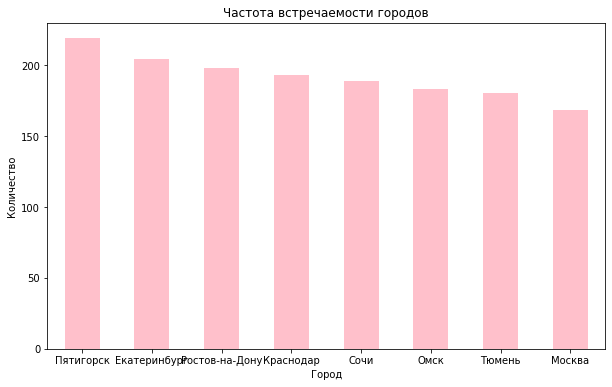

In [19]:
city_counts = users['city'].value_counts()
city_counts_table = pd.DataFrame({'Город': city_counts.index, 'Количество': city_counts.values})
display(city_counts_table)
users['city'].value_counts().plot(kind = 'bar', figsize=(10, 6), title = 'Частота встречаемости городов', xlabel = 'Город',
ylabel = 'Количество', color='pink', rot =0)

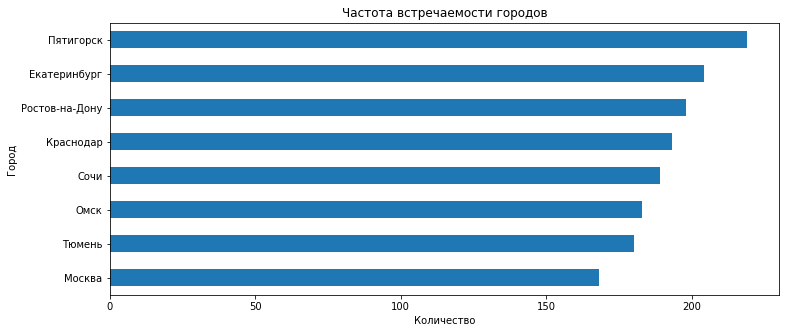

In [20]:
users['city'].value_counts(ascending = True).plot(kind = 'barh', figsize=(12, 5), 
                                                  title = 'Частота встречаемости городов')
plt.ylabel('Город')
plt.xlabel('Количество')
plt.show()

##### Соотношение пользователей с подпиской и без подписки

<AxesSubplot:title={'center':'Соотношение пользователей с подпиской и без подписки'}, ylabel='subscription_type'>

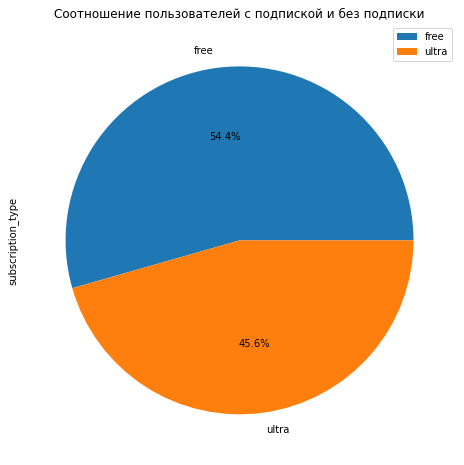

In [21]:
users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title = 'Соотношение пользователей с подпиской и без подписки', legend = ['free', 'ultra'])
#(autopct='%1.1f%%') отображают процентное соотношение каждой категории на диаграмме
# Для понимания добавила легенду, что бы понять, какой сектор относится к какой категории подписки

##### Возраст пользователей

Text(0, 0.5, 'Количество')

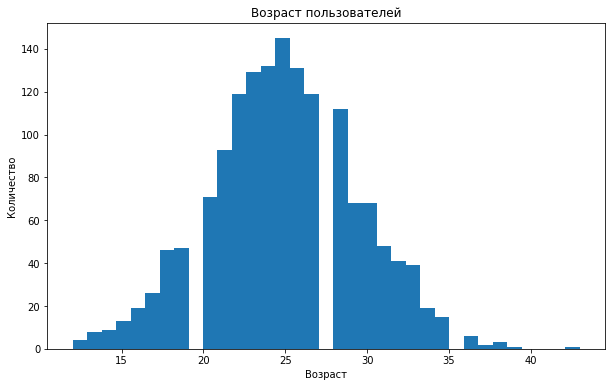

In [22]:
users['age'].plot(kind='hist', bins=35, figsize=(10, 6), title = 'Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')

##### Расстояние, которое пользователь преодолел за одну поездку

Text(0, 0.5, 'Количество')

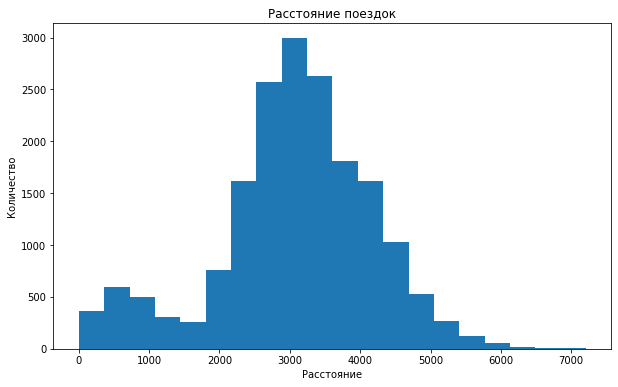

In [23]:
rides['distance'].plot(kind='hist', bins=20, figsize=(10, 6), title='Расстояние поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество')

In [24]:
distance_stats = rides['distance'].describe()

print("Статистика по расстоянию:")
print(distance_stats)

Статистика по расстоянию:
count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


##### Продолжительность поездок

Text(0, 0.5, 'Количество')

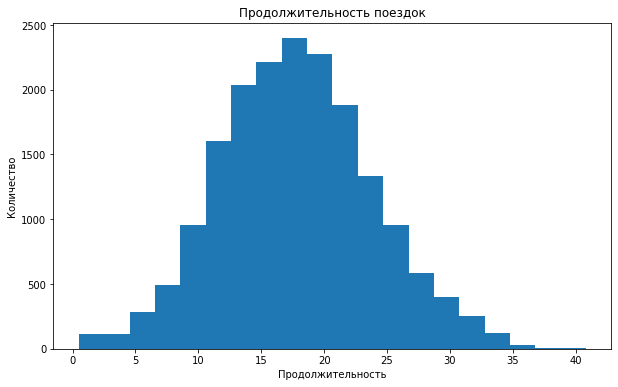

In [25]:
rides['duration'].plot(kind='hist', bins=20, figsize=(10, 6), title ='Продолжительность поездок')
plt.xlabel('Продолжительность')
plt.ylabel('Количество')

In [26]:
duration_stats = rides['duration'].describe()

print("\nСтатистика по продолжительности:")
print(duration_stats)


Статистика по продолжительности:
count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


**На основе проведенного исследовательского анализа данных, можно сделать следующие выводы:** 

1. Частота встречаемости городов: Большинство пользователей проживает в Москве, Санкт-Петербурге 

2. Соотношение пользователей с подпиской и без подписки: Около 54% пользователей имееют подписку, а остальные пользователи без подписки.

3. Возраст пользователей: Большинство пользователей находятся в возрастной группе от 20 до 30 лет.

**Дополнение после комментария**
1. Расстояние, которое пользователь преодолел за одну поездку:

* Основной диапазон от 0.85 до 7211.01,.
* Минимальное значение 0.85
* Максимальное значение 7211
* Наличие аномальных значений или выбросов не замечено, значения в предалах нормы
2.  Продолжительность поездок:

* Основной диапазон от 0.50 до 41.
* Минимальное значение 0.50
* Максимальное значение 41
* Наличие аномальных значений или выбросов не замечено, значения в предалах нормы

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge()

In [27]:
# Объединение данных
merged_data = rides.merge(users, on='user_id').merge(subscriptions, on='subscription_type')
merged_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
* С данными о пользователях без подписки
* С данными о пользователях с подпиской


In [28]:
# Без подписки
users_without_subscription = merged_data[merged_data['subscription_type'] == 'free']

# С подпиской
users_with_subscription = merged_data[merged_data['subscription_type'] == 'ultra']

In [24]:
# Код ревьюера
display(merged_data.shape[0])
display(users_without_subscription.shape[0])
users_with_subscription.shape[0]

18068

11568

6500

##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

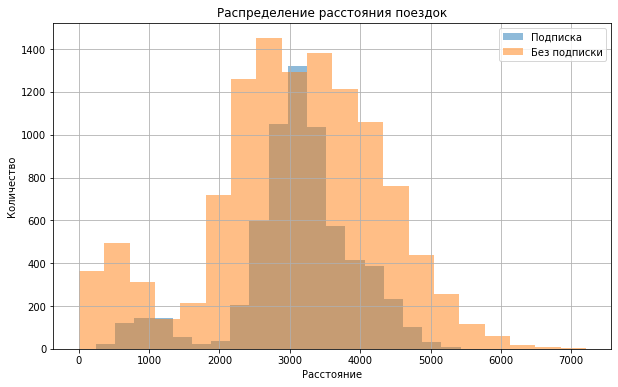

In [29]:
users_with_subscription['distance'].hist(bins=20, alpha=0.5, label='Подписка', figsize=(10, 6))
users_without_subscription['distance'].hist(figsize=(10, 6), bins=20, alpha=0.5, label='Без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.title('Распределение расстояния поездок')
plt.legend()

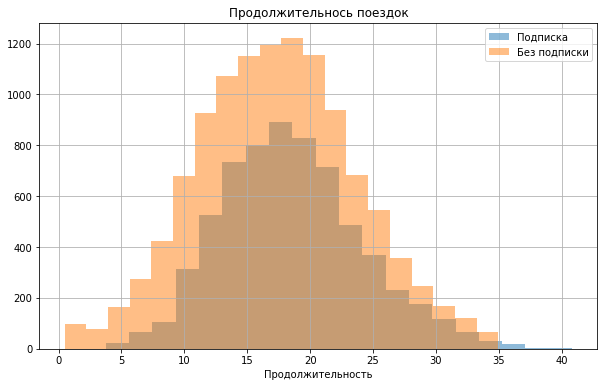

In [26]:
users_with_subscription['duration'].hist(bins=20, alpha=0.5, label='Подписка',  figsize=(10, 6))
users_without_subscription['duration'].hist(bins=20, alpha=0.5, label='Без подписки', figsize=(10, 6))

plt.xlabel('Продолжительность')
plt.title('Продолжительнось поездок')
plt.legend()

Text(0, 0.5, 'Продолжительность')

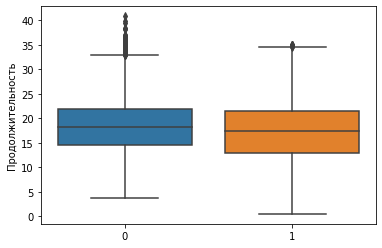

In [30]:
sns.boxplot(data=[users_with_subscription['duration'], users_without_subscription['duration']], orient='v')
plt.ylabel('Продолжительность')

Text(0, 0.5, 'Продолжительность')

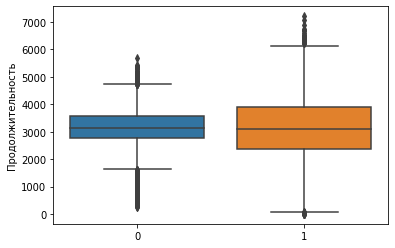

In [28]:
sns.boxplot(data=[users_with_subscription['distance'], users_without_subscription['distance']], orient='v')
plt.ylabel('Продолжительность')

**Выводы:** Объединение данных позволило получить более полную информацию о пользователях, их поездках и подписках. Визуализация данных подтверждает различия между пользователями с подпиской и без подписки в расстоянии и продолжительности поездок. 

* Пользователи с подпиской имеют более широкий диапазон расстояний по сравнению с пользователями без подписки. Пользователи без подписки в основном совершают более короткие поездки.
* Боксплот "Распределение времени поездок" показывает, что пользователи с подпиской имеют большую медианную продолжительность поездок и более широкий интерквартильный размах по сравнению с пользователями без подписки.

#### Шаг 5. Подсчёт выручки

In [31]:
merged_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [32]:
# Округление продолжительности каждой поездки вверх
merged_data['duration'] = np.ceil(merged_data['duration'])

# Создание датафрейма с агрегированными данными о поездках и суммарного времени для каждого пользователя за каждый месяц
monthly_summary = merged_data.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'date': 'count',
    'subscription_type': 'first',  # Добавляем столбец с типом подписки
    'start_ride_price': 'first',  # Добавляем столбец с ценой старта поездки
    'minute_price': 'first',  # Добавляем столбец с ценой за минуту поездки
}).reset_index()


##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26

In [33]:
def calculate_revenue(row):
    if row['subscription_type'] == 'free':
        start_price = 50 
        minute_price = 8
        subscription_fee = 0
    else:
        start_price = 0 
        minute_price = 6
        subscription_fee = 199
    duration = np.ceil(row['duration'])
    
    if row['subscription_type'] == 'ultra':
        revenue = subscription_fee + (minute_price * duration)
    else:
        revenue = (start_price * row['date']) + (minute_price * duration)
    return revenue

monthly_summary['revenue'] = monthly_summary.apply(calculate_revenue, axis=1)
display(monthly_summary)

,user_id,month,distance,duration,date,subscription_type,start_ride_price,minute_price,revenue
0,1,1,7027.511294,42.0,2,ultra,0,6,451.0
1,1,4,754.159807,7.0,1,ultra,0,6,241.0
2,1,8,6723.470560,46.0,2,ultra,0,6,475.0
3,1,10,5809.911100,32.0,2,ultra,0,6,391.0
4,1,11,7003.499363,56.0,3,ultra,0,6,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,50,8,308.0
11327,1534,8,7622.453034,48.0,2,free,50,8,484.0
11328,1534,9,4928.173852,23.0,1,free,50,8,234.0
11329,1534,11,13350.015305,78.0,4,free,50,8,824.0


In [34]:
# Код ревьюера
print(monthly_summary.groupby('subscription_type')['revenue'].mean())

monthly_summary.head()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue, dtype: float64


,user_id,month,distance,duration,date,subscription_type,start_ride_price,minute_price,revenue
0,1,1,7027.511294,42.0,2,ultra,0,6,451.0
1,1,4,754.159807,7.0,1,ultra,0,6,241.0
2,1,8,6723.470560,46.0,2,ultra,0,6,475.0
3,1,10,5809.911100,32.0,2,ultra,0,6,391.0
4,1,11,7003.499363,56.0,3,ultra,0,6,535.0


**Выводы**

1. По условию создан датафрейм monthly_summary, содержащий данные о поездках для каждого пользователя за каждый месяц. Включены следующие столбцы: user_id, month, distance, duration, date, subscription_type, start_ride_price, minute_price.

2. Добавлен столбец revenue, который содержит информацию о помесячной выручке, принесенной каждым пользователем. Выручка рассчитывается на основе условий оплаты для подписчиков и пользователей без подписки.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

#####  Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Нулевая гипотеза**- Среднее время поездки пользователей с подпиской равно среднему времени поездик пользователей без подписки
**Альтернативная гипотеза** - Среднее время поездки пользователей с подпиской больше среднего времени поездок пользователей без подписки

In [35]:
# Выборка у подписчиков
duration_subscribers = merged_data[merged_data['subscription_type'] == 'ultra']['duration']

# без подписки
duration_non_subscribers = merged_data[merged_data['subscription_type'] == 'free']['duration']

# Проверка гипотезы с помощью t-теста
t_statistic, p_value = ttest_ind(duration_subscribers, duration_non_subscribers, alternative='greater', equal_var=False)

if p_value < 0.05:
    print("Гипотеза что подписчики тратят больше времени на поездки, подтверждается.")
else:
    print("Нет достаточных оснований для подтверждения гипотезы")

Гипотеза что подписчики тратят больше времени на поездки, подтверждается.


##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гипотеза** - Среднее расстояние с подпиской == или < 3130 метров.
**Альтернативная гипотеза** - среднее расстояние поездок подписчиков > 3130 метров.
Для проверки гипотезы использую одностороннюю t-тест с альтернативной гипотезой "less" (односторонняя,  в меньшую сторону от нулевой гипотезы)

In [37]:
from scipy.stats import ttest_1samp

distance_subscribers = merged_data[merged_data['subscription_type'] == 'ultra']['distance']

t_statistic, p_value = ttest_1samp(distance_subscribers, 3130, alternative='greater')

if p_value < 0.05:
    print("Гипотеза что расстояние не превышает 3130 м, отвергается")
else:
    print("Нет достаточных оснований что с подпиской за одну поездку, превышает 3130 м")

print("Значение p-value:", p_value)

Нет достаточных оснований что с подпиской за одну поездку, превышает 3130 м
Значение p-value: 0.9195368847849785


##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Нулевая гипотеза - Помесячная выручка от пользователей с подпиской не превышает выручку от пользователей без подписки.

Альтернативная гипотеза - Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Для проверки гипотезы использую одностороннюю t-тест с альтернативной гипотезой "greater" (односторонняя, больше)

In [38]:
revenue_sub = monthly_summary[monthly_summary['subscription_type'] == 'ultra']['revenue']

# Выборка без подписки
revenue_non_sub = monthly_summary[monthly_summary['subscription_type'] == 'free']['revenue']
t_statistic, p_value = ttest_ind(revenue_sub, revenue_non_sub, equal_var=False, alternative='greater')

# Вывод результатов
if p_value < 0.05:
    print("Гипотеза помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, подтверждается")
else:
    print("Нет достаточных оснований для подтверждения гипотезы")

Гипотеза помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, подтверждается


##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки гипотезы можно использовать парный t-тест для зависимых выборок
* Нулевая гипотеза - Обновление серверов не привело к значимому снижению количества обращений в техподдержку.
* Альтернативная гипотеза будет односторонней - Обновление серверов привело к значимому снижению количества обращений в техподдержку.

**Подтверждение гипотез**
6.1: Гипотеза что пользователи с подпиской тратят больше времени на поездки, подтверждается

6.2: Результаты t-теста показали, что  нет достаточных оснований для вывода о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

6.3: Гипотеза о том, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки, подтверждается. 

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


Минимальное количество промокодов: [1161]


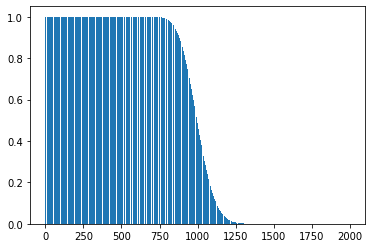

In [54]:
p = 0.1  
n = np.arange(0, 2000)  


min_promo = []


for promo in n:
    prob = binom.cdf(99, promo, p)
    if prob <= 0.05:
        min_promo.append(promo)
        break

plt.bar(range(0, len(prob_list)), prob_list)

print("Минимальное количество промокодов:", min_promo)

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [37]:
from scipy.stats import norm

p = 0.4  # Вероятность открытия 
n = 1000000  # количество уведомлений

mean = n * p
std = np.sqrt(n * p * (1 - p))

# Оценка вероятности
prob = norm.cdf(399500, mean, std)
print("Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:", prob * 100, "%")

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.371708296369768 %


In [38]:
import scipy.stats as stats

mu = 400000
sigma = 489.897
x = 399500

prob = stats.norm.cdf(x, mu, sigma)
print("Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:", prob * 100, "%")

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.371661464935887 %


#### Общие выводы 

**По результатам анализа данных GoFast можно сделать следующие общие выводы:**

1. Частота встречаемости городов: Большинство пользователей проживает в Москве и Санкт-Петербурге, что указывает на популярность сервиса в крупных городах.

2. Распределение по типу пользователя: Большинство пользователей GoFast не имеют подписки и используют сервис в режиме оплаты за каждую поездку. Однако количество пользователей с подпиской также растет.

3. Возраст пользователей: Большинство пользователей находятся в возрастной группе от 20 до 30 лет.

4. Продолжительность и расстояние поездок: Средняя продолжительность поездок пользователей с подпиской выше, чем у пользователей без подписки. Однако среднее расстояние поездок для обеих групп примерно одинаково и не превышает оптимальное расстояние.

5. Помесячная выручка: Пользователи с подпиской приносят больше выручки, чем пользователи без подписки. Это связано с тем, что пользователи с подпиской платят фиксированную сумму каждый месяц, а также могут совершать дополнительные поездки, которые увеличивают сумму в выручке.

Таким образом, пользователи с подпиской являются более выгодными для компании, так как они не только приносят стабильную выручку, но и более активно пользуются сервисом. 


Рекомендуется направлять маркетинговые усилия на увеличение количества подписчиков и повышение их удержания в системе.